In [1]:
from pyDOE import *
import pandas as pd
import numpy as np

def construct_df(x,r):
    df=pd.DataFrame(data=x,dtype='float32')
    for i in df.index:
        for j in range(len(list(df.iloc[i]))):
            df.iloc[i][j]=r[j][int(df.iloc[i][j])]
    return df

def build_box_behnken(factor_level_ranges,center=1):
    """
    Builds a Box-Behnken design dataframe from a dictionary of factor/level ranges.
    Note 3 levels of factors are necessary. If not given, the function will automatically create 3 levels by linear mid-section method.
    Example of the dictionary:
    {'Pressure':[50,60,70],'Temperature':[290, 320, 350],'Flow rate':[0.9,1.0,1.1]}
	
	In statistics, Box–Behnken designs are experimental designs for response surface methodology, devised by George E. P. Box and Donald Behnken in 1960, to achieve the following goals:
		* Each factor, or independent variable, is placed at one of three equally spaced values, usually coded as −1, 0, +1. (At least three levels are needed for the following goal.)
		* The design should be sufficient to fit a quadratic model, that is, one containing squared terms, products of two factors, linear terms and an intercept.
		* The ratio of the number of experimental points to the number of coefficients in the quadratic model should be reasonable (in fact, their designs kept it in the range of 1.5 to 2.6).*estimation variance should more or less depend only on the distance from the centre (this is achieved exactly for the designs with 4 and 7 factors), and should not vary too much inside the smallest (hyper)cube containing the experimental points.
	"""
    for key in factor_level_ranges:
        if len(factor_level_ranges[key])==2:
            factor_level_ranges[key].append((factor_level_ranges[key][0]+factor_level_ranges[key][1])/2)
            factor_level_ranges[key].sort()
            print(f"{key} had only two end points. Creating a mid-point by averaging them")
    
    factor_count=len(factor_level_ranges)
    factor_lists=[]
    
    for key in factor_level_ranges:
        factor_lists.append(factor_level_ranges[key])
    
    x = bbdesign(factor_count,center=center)
    x=x+1 #Adjusting the index up by 1

    df=construct_df(x,factor_lists)
    df.columns=factor_level_ranges.keys()
    
    return df

In [2]:
import pandas as pd
dfX = pd.read_excel('C:\\Apps\\Source\\Mars_MBAL_Openserver_DOE3.xlsx', sheet_name="DOE_BB")
Dict = {}
list1 = dfX.columns
for i in range(len(list1)):
    Dict[dfX.columns[i]] = list(dfX.iloc[:,i].values)

df2 = build_box_behnken(Dict)

C:\Users\Mohit.M.Gupta.ASIA-PAC\Anaconda3\lib\site-packages\openpyxl\reader\workbook.py:88: UserWarning: File contains an invalid specification for Module5. This will be removed
  warn(msg)


In [3]:
# Import modules for OpenServer functions
import win32com.client
import sys
import time

class OpenServer():
    "Class for holding ActiveX reference. Allows license disconnection"
    def __init__(self):
        self.status = "Disconnected"
        self.OSReference = None
    
    def Connect(self):
        self.OSReference = win32com.client.Dispatch("PX32.OpenServer.1")
        self.status = "Connected"
        print("OpenServer connected")
        
    def Disconnect(self):
        self.OSReference = None
        self.status = "Disconnected"
        print("OpenServer disconnected")
        
def GetAppName(sv):
    # function for returning app name from tag string
    pos = sv.find(".")
    if pos < 2:
        sys.exit("GetAppName: Badly formed tag string")
    app_name = sv[:pos]
    if app_name.lower() not in ["prosper", "mbal", "gap", "pvt", "resolve",
                                   "reveal"]:
        sys.exit("GetAppName: Unrecognised application name in tag string")
    return app_name


def DoCmd(OpenServe, cmd):
    # perform a command and check for errors
    lerr = OpenServe.OSReference.DoCommand(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoCmd: " + err)


def DoSet(OpenServe, sv, val):
    # set a value and check for errors
    lerr = OpenServe.OSReference.SetValue(sv, val)
    app_name = GetAppName(sv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSet: " + err)
        
def DoGet(OpenServe, gv):
    # get a value and check for errors
    get_value = OpenServe.OSReference.GetValue(gv)
    app_name = GetAppName(gv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGet: " + err)
    return get_value


def DoSlowCmd(OpenServe, cmd):
    # perform a command then wait for command to exit and check for errors
    step = 0.001
    app_name = GetAppName(cmd)
    lerr = OpenServe.OSReference.DoCommandAsync(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)
    while OpenServe.OSReference.IsBusy(app_name) > 0:
        if step < 2:
            step = step*2
        time.sleep(step)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)


def DoGAPFunc(OpenServe, gv):
    DoSlowCmd(gv)
    DoGAPFunc = DoGet(OpenServe, "GAP.LASTCMDRET")
    lerr = OpenServe.OSReference.GetLastError("GAP")
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGAPFunc: " + err)
    return DoGAPFunc

def OSOpenFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.OPENFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSOpenFile: " + err)


def OSSaveFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.SAVEFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSSaveFile: " + err)

In [4]:
import os
petex = OpenServer()
petex.Connect()
cwd = os.getcwd()
OSOpenFile(petex, 'C:\\Apps\\Source\\mars_case1.mbi', 'MBAL')

OpenServer connected


In [5]:
import pandas as pd
df = pd.read_excel('C:\\Apps\\Source\\Mars_MBAL_Openserver_DOE3.xlsx', sheet_name="MBAL_parameters")
#df2 = pd.read_excel('C:\\Apps\\Source\\Mars_MBAL_Openserver_DOE2.xlsm', sheet_name="DOE_INPUT")

list1 = df['MBAL Parameter Name'].values
df['New'] = df.index

C:\Users\Mohit.M.Gupta.ASIA-PAC\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [6]:
def mbalinput(k):
    c=-1
    for i in list1:
        c=c+1
        c=int(c)
        para = df['Link to Uncertainity'].loc[c]
        if (para != 'None'):
            df['New'].loc[c]=df2[para].loc[k]
        else:
            df['New'].loc[c] = 0
        par1 = i
        if (df['New'].loc[c] == -1):
            par2 = 'Low'
        elif(df['New'].loc[c] == 0):
             par2 ='Base'
        else:
             par2 ='High'
        par3 = df[par2].loc[c]

        DoSet(petex,par1,par3)

def runmbal():
    DoCmd(petex, 'MBAL.MB.PVT.INPUT.MATCHALL (OIL)')
    DoCmd(petex, 'MBAL.MB.PVT.INPUT.CALCULATE')
    DoCmd(petex, 'MBAL.MB.RunPrediction')

def results():
    RF = DoGet(petex, 'MBAL.MB[0].TRES[{Prediction}][{Tank01}][61].OILRECOVER')
    UR = DoGet(petex,"MBAL.MB[0].TRES[{Prediction}][{Prediction}][61].CUMOIL")
    res =[RF,UR]
    return res

def resultstime(k):
    timestep = int(DoGet(petex,"MBAL.MB[0].TRES[{Prediction}][{Tank01}].COUNT"))

    df3 = pd.DataFrame(columns=['CASE','Time','Pressure','OilRate'])

    for i in range(timestep):
        df3.at[i, 'Time'] = (DoGet(petex, 'MBAL.MB[0].TRES[{Prediction}][{Tank01}]['+str(i)+'].TIME'))
        df3.at[i, 'Pressure'] = float(DoGet(petex, 'MBAL.MB[0].TRES[{Prediction}][{Tank01}]['+str(i)+'].TANKPRESS'))
        df3.at[i, 'OilRate'] = float(DoGet(petex, 'MBAL.MB[0].TRES[{Prediction}][{Tank01}]['+str(i)+'].OILRATE'))
        df3.at[i, 'CASE'] = 'CASE'+str(k+1)
    return df3

In [7]:
df2['RF'] = df2.index
df2['UR'] = df2.index

df2['RF'].astype('float64')
df2['UR'].astype('float64')

dfresults = pd.DataFrame(columns=['CASE','Time','Pressure','OilRate'])

for i in range(df2.shape[0]):
    mbalinput(i)
    runmbal()
    r1 = results()
    df_temp = resultstime(i)
    n1 = float(r1[0])
    n2 = float(r1[1])
    df2.loc[i, 'RF'] = n1
    df2.loc[i, 'UR'] = n2
    dfresults= pd.concat([dfresults,df_temp])


C:\Users\Mohit.M.Gupta.ASIA-PAC\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
with pd.ExcelWriter('C:\\Apps\\Source\\Results.xlsx') as writer:  
    df2.to_excel(writer, sheet_name='DOE_OUTPUT',index=False)
    dfresults.to_excel(writer, sheet_name='TIME_RESULTS',index=False)

In [9]:
petex.Disconnect()

OpenServer disconnected


<AxesSubplot:ylabel='Frequency'>

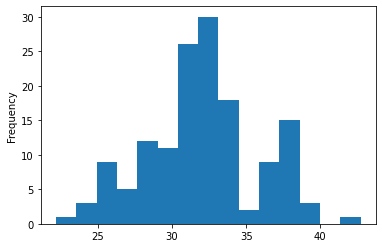

In [11]:
df2['RF'].plot(kind='hist', bins=15)

<AxesSubplot:ylabel='Frequency'>

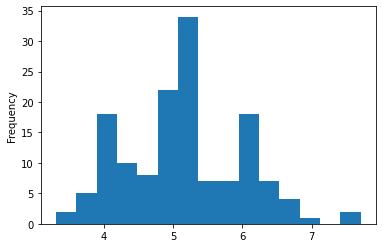

In [12]:
df2['UR'].plot(kind='hist', bins=15)

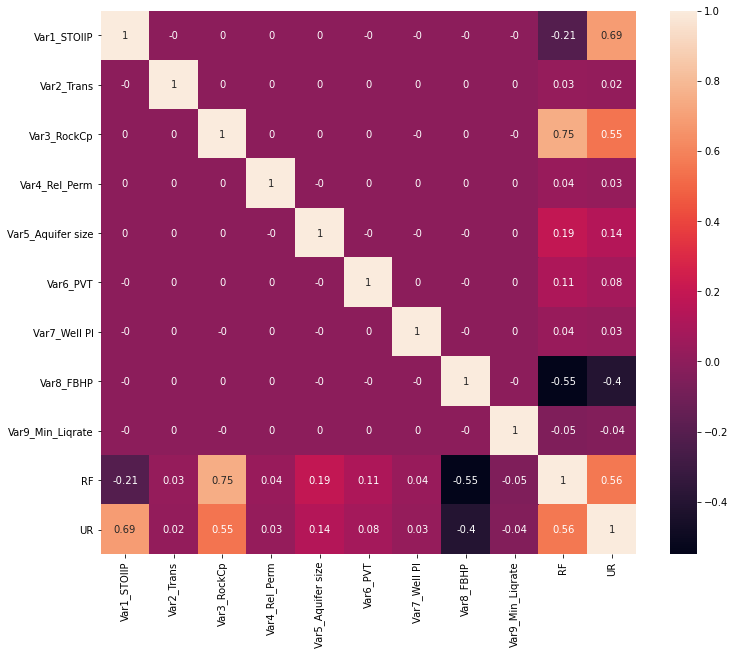

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
dfcor = df2.corr()
dfcor = dfcor.round(2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(dfcor, annot=True)
plt.show()

<AxesSubplot:>

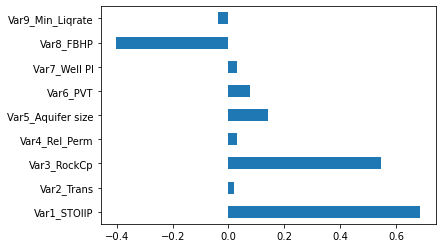

In [13]:
dfcor['UR'][:9].plot(kind='barh')

<AxesSubplot:>

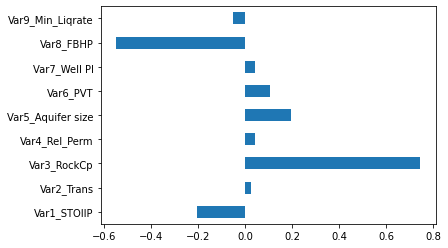

In [14]:
dfcor['RF'][:9].plot(kind='barh')

In [15]:
import numpy as np

data = df2['RF'].to_numpy()

p90_rf = np.percentile(data,90)
p50_rf = np.percentile(data,50)
p10_rf = np.percentile(data,10)

print("P90 RF: ",round(p90_rf,1))
print("P50 RF: ",round(p50_rf,1))
print("P10 RF: ",round(p10_rf,1))

P90 RF:  37.5
P50 RF:  32.0
P10 RF:  26.6


In [48]:
cases = dfresults['CASE'].unique()

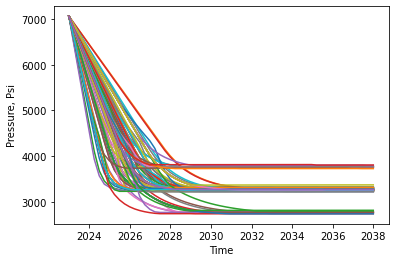

In [59]:
fig, ax = plt.subplots()
for case in cases:
    df5=dfresults[dfresults['CASE']==case]
    ax.plot(df5['Time'], df5['Pressure'])
plt.xlabel("Time")
plt.ylabel("Pressure, Psi")
plt.savefig('Pressure.png')

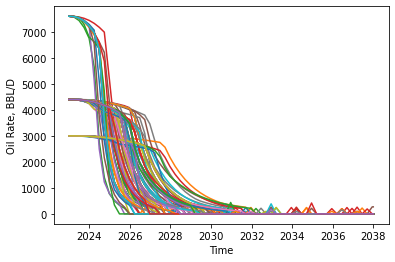

In [60]:
fig, ax = plt.subplots()
for case in cases:
    df5=dfresults[dfresults['CASE']==case]
    ax.plot(df5['Time'], df5['OilRate'])
plt.xlabel("Time")
plt.ylabel("Oil Rate, BBL/D")
plt.savefig('rate.png')

In [69]:
df10={}
df10=pd.DataFrame(df10)
writer = pd.ExcelWriter('C:\\Apps\\Source\\Results.xlsx', engine = 'xlsxwriter')
df10.to_excel(writer, sheet_name='Sheet1')

worksheet = writer.sheets['Sheet1']
worksheet.insert_image('A2','rate.png')
worksheet.insert_image('M2','Pressure.png')
writer.save()